In [1]:
import math
from typing import Any

import torch

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto
from torch.nn import init
from torch.distributions.cauchy import Cauchy
from torch.distributions.laplace import Laplace
seed=0
#torch.cuda.manual_seed_all(seed)
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()
import gc

gc.collect()

12

In [2]:
def stats(tensor):
    # Calculate the mean
    mean = torch.mean(tensor)
    # Calculate the variance
    second = torch.mean(torch.pow(tensor,2))
    third = torch.mean(torch.pow(tensor,3))
    fourth=torch.mean(torch.pow(tensor,4))
    # Calculate the standard deviation
    var=torch.var(tensor)
    std = torch.sqrt(var)
    # Calculate the z-scores
    zscores = (tensor - mean) / std
    # Calculate the skewness
    skew = torch.mean(zscores ** 3)
    # Calculate the kurtosis
    kurt = torch.mean(zscores ** 4) - 3
    print("fourth moment")
    print(fourth)
    #Return the results as a tuple
    return mean, second, skew, kurt

In [3]:
weight_tuning=1
## initial =1
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #if reset=True:
            
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
        bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
        #init.uniform_(self.weight, -bound,bound)
        m = Cauchy(torch.tensor([0.0]), torch.tensor([bound]))
       
        
        
        a=m.sample(torch.Size([self.in_features*self.out_features]))[:,0]
        a=a.resize(self.out_features,self.in_features)
        self.weight=torch.nn.Parameter(a)
        #init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.bias)
            bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
            #init.uniform_(self.weight, -bound,bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [4]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2



font = {
        'size'   : 26}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,mu,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.mu=mu
        self.encoder_output_layer = Linear(
            in_features=input_shape, out_features=encoder_output_shape
        ,bias=False)
        self.decoder_output_layer = Linear(
            in_features=encoder_output_shape, out_features=input_shape
        ,bias=False)

        #self.encoder_input_layer.weight=torch.nn.Parameter(torch.rand(self.encoder_input_layer.weight.size))
        
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):


        code = self.encoder_output_layer(features)
        result = torch.tanh(code)
        return code
    
    def decoder(self,code):  
        activation = self.decoder_output_layer(code)
        reconstructed = torch.tanh(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [5]:

#transform=
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

#print(model.encoder_input_layer.weight)

cuda


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [7]:
import matplotlib.pyplot as plt 
epochs=1000
asymptotic_repetition=150


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=20,50
spectral_calculation=5
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3)
interval=50

In [8]:
def add_gaussian_noise(inputs,strength):
    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result
def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model(x_train)
    return x_train,y_pred,model 
def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=1
    overall_distribution=np.asarray([])
    y_pred=initial_input.to(device)
    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=y_pred
        
        y_pred=model(x_train)
        mean_jacobian=torch.eye(input_size,output_size).to(device)
        
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1
            mean_jacobian*=res
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

        norm=torch.norm(mean_jacobian).cpu()
        #mean_jacobian*=(1/np.sqrt(output_size)*norm)**(1/no_of_images)
        #mean_jacobian=mean_jacobian/no_of_images
        ave_jac*=(1/np.sqrt(output_size)*norm)**(1/no_of_repetition*1/no_of_images)
        print(ave_jac)
        print(norm)
        print(norm**(1/no_of_repetition*1/no_of_images))
    #average_jacobian=ave_jac/no_of_repetition
    print(jacobian)
    return ave_jac,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
    ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_new,y_pred_unperturbed,no_of_images,no_of_repetition)
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        #diff=0
        diff=torch.ones(1,device=device)
        temp=0
        #print(len(cutoff))
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
            if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                result=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            if result.cpu().detach().numpy()<2**-52:
                result=torch.Tensor([2**-52]).to(device)
            #temp=result
            diff*=result**(1/no_of_image)
            
            #print(j)
            if result>cutoff[j] and i==no_of_repetition-1:
                chaos+=1
        if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
            diff=torch.Tensor([1*10**38]).to(device)
            print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
        if diff.cpu().detach().numpy()<2**-52:
            diff=torch.Tensor([2**-52]).to(device)
        distance.append(diff.cpu().detach().numpy())

    return distance,hidden_layer,chaos/no_of_image,ave_jac

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]



running
tensor(0.7473)
tensor(8.8751e-126)
tensor(0.7498)
tensor(0.6043)
tensor(1.5403e-91)
tensor(0.8113)
tensor(0.5232)
tensor(7.4055e-62)
tensor(0.8687)
tensor(0.4763)
tensor(4.3473e-40)
tensor(0.9134)
tensor(0.4566)
tensor(1.2437e-17)
tensor(0.9618)
tensor(0.4074)
tensor(9.3940e-49)
tensor(0.8953)
tensor(0.3405)
tensor(3.4380e-77)
tensor(0.8386)
tensor(0.2534)
tensor(1.5965e-127)
tensor(0.7468)
tensor(0.2026)
tensor(1.3985e-96)
tensor(0.8019)
tensor(0.1769)
tensor(5.1401e-58)
tensor(0.8764)
tensor(0.1602)
tensor(1.7737e-42)
tensor(0.9083)
tensor(0.1531)
tensor(4.9908e-19)
tensor(0.9587)
tensor(0.1377)
tensor(2.6869e-45)
tensor(0.9025)
tensor(0.1165)
tensor(6.0394e-72)
tensor(0.8488)
tensor(0.0871)
tensor(1.1232e-125)
tensor(0.7500)
tensor(0.0705)
tensor(5.6117e-91)
tensor(0.8124)
tensor(0.0612)
tensor(1.0702e-60)
tensor(0.8710)
tensor(0.0552)
tensor(1.1526e-43)
tensor(0.9059)
tensor(0.0533)
tensor(3.4436e-15)
tensor(0.9672)
tensor(0.0477)
tensor(1.3484e-47)
tensor(0.8977)
tensor(0.

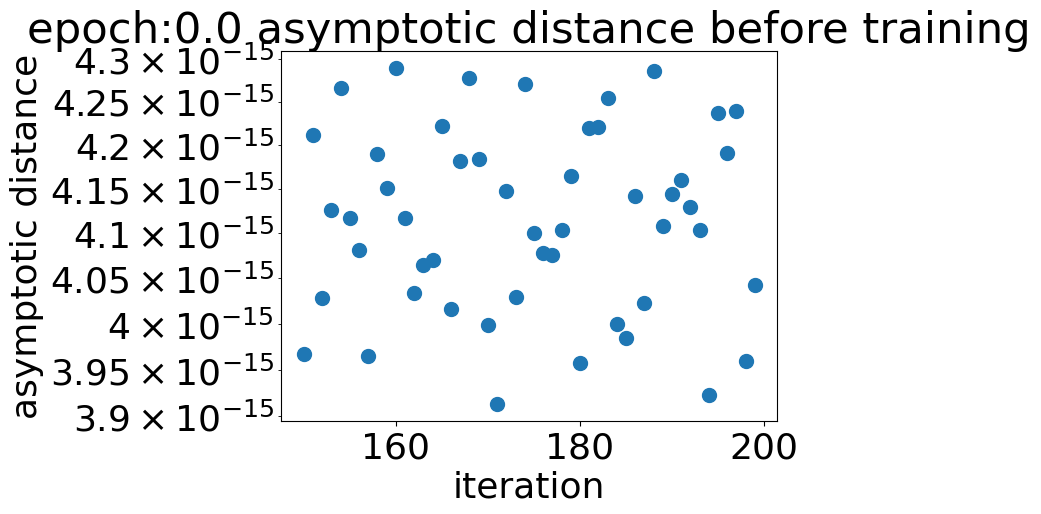

epoch : 1/1000, training loss = 0.975785,validation loss = 0.877330
epoch : 2/1000, training loss = 0.823169,validation loss = 0.782991
epoch : 3/1000, training loss = 0.764591,validation loss = 0.747553
epoch : 4/1000, training loss = 0.734243,validation loss = 0.718757
epoch : 5/1000, training loss = 0.707590,validation loss = 0.694627
epoch : 6/1000, training loss = 0.684556,validation loss = 0.675144
epoch : 7/1000, training loss = 0.670162,validation loss = 0.663292
epoch : 8/1000, training loss = 0.656920,validation loss = 0.649991
epoch : 9/1000, training loss = 0.645644,validation loss = 0.639639
epoch : 10/1000, training loss = 0.636154,validation loss = 0.631880
epoch : 11/1000, training loss = 0.628891,validation loss = 0.624030
epoch : 12/1000, training loss = 0.621674,validation loss = 0.617319
epoch : 13/1000, training loss = 0.615193,validation loss = 0.611048
epoch : 14/1000, training loss = 0.607457,validation loss = 0.601500
epoch : 15/1000, training loss = 0.599768,v

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.9806)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.9616)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.9430)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.9247)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.9068)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.8893)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.8720)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.8552)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.8386)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.8223)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.8064)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.7908)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.7755)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.7605)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.7457)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.7313)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.7171)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.7032)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.6896)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.6762)
tensor(8.9631e-08)
tensor(0.9839)
tensor(0.6631)
tenso

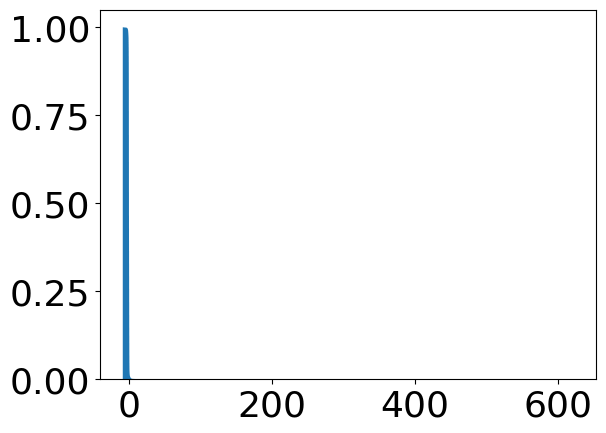

fourth moment
tensor(19169684.1945, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(0.2200, device='cuda:0', grad_fn=<MeanBackward0>), tensor(50.0859, device='cuda:0', grad_fn=<MeanBackward0>), tensor(86.9113, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7640.6088, device='cuda:0', grad_fn=<SubBackward0>))


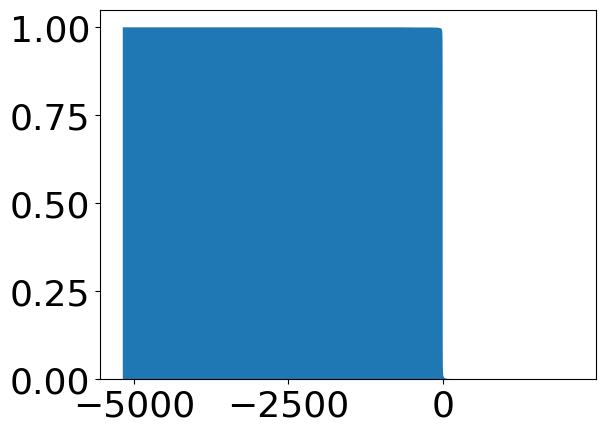

fourth moment
tensor(9.4691e+10, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(-0.2187, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4294.3986, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-58.5670, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5129.6138, device='cuda:0', grad_fn=<SubBackward0>))


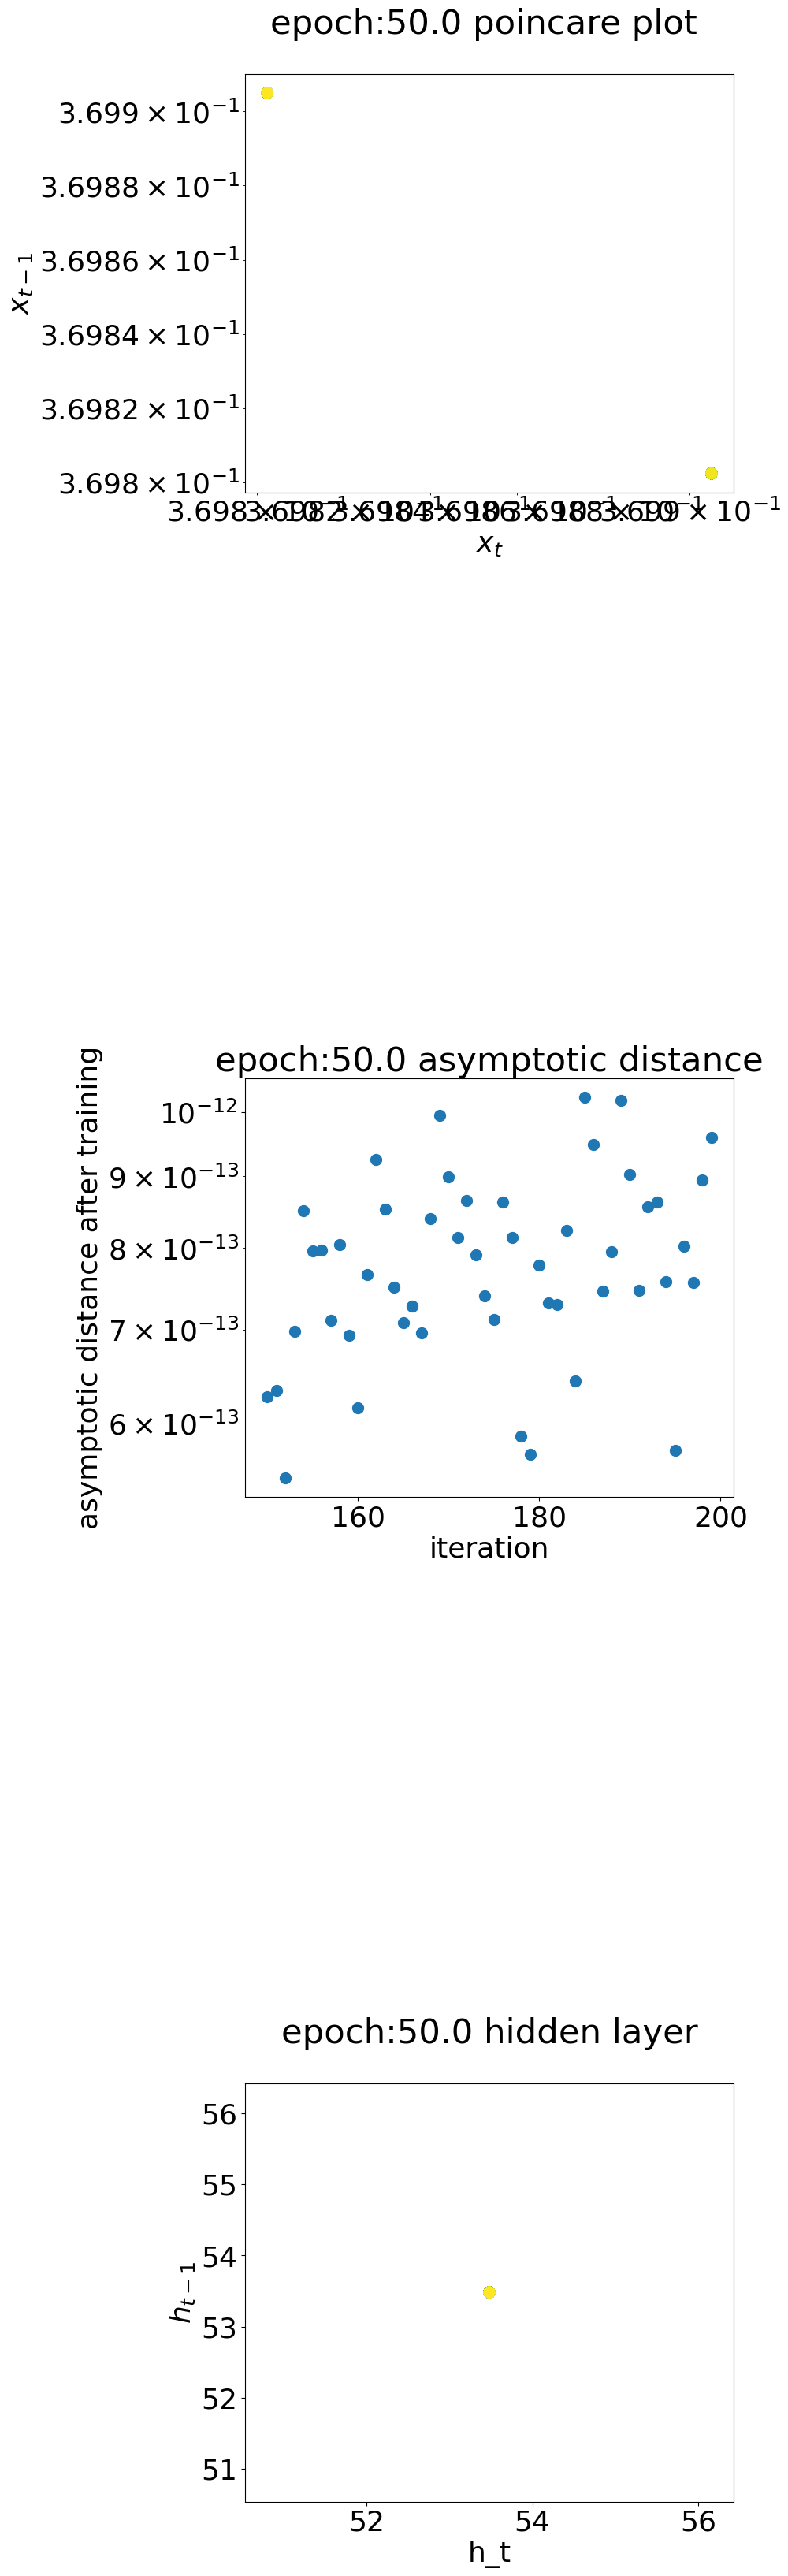

epoch : 51/1000, training loss = 0.503388,validation loss = 0.501460
epoch : 52/1000, training loss = 0.501028,validation loss = 0.499235
epoch : 53/1000, training loss = 0.499932,validation loss = 0.498633
epoch : 54/1000, training loss = 0.498938,validation loss = 0.497145
epoch : 55/1000, training loss = 0.497602,validation loss = 0.496081
epoch : 56/1000, training loss = 0.496159,validation loss = 0.493837
epoch : 57/1000, training loss = 0.494399,validation loss = 0.493306
epoch : 58/1000, training loss = 0.493553,validation loss = 0.491877
epoch : 59/1000, training loss = 0.492035,validation loss = 0.490137
epoch : 60/1000, training loss = 0.490364,validation loss = 0.489012
epoch : 61/1000, training loss = 0.488939,validation loss = 0.487440
epoch : 62/1000, training loss = 0.487938,validation loss = 0.486741
epoch : 63/1000, training loss = 0.486645,validation loss = 0.484773
epoch : 64/1000, training loss = 0.485312,validation loss = 0.484229
epoch : 65/1000, training loss = 0

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.9875)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.9752)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.9630)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.9510)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.9391)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.9274)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.9158)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.9044)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8931)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8819)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8709)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8600)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8493)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8387)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8282)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8179)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.8077)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.7976)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.7876)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.7778)
tensor(9.7805e-05)
tensor(0.9908)
tensor(0.7681)
tenso

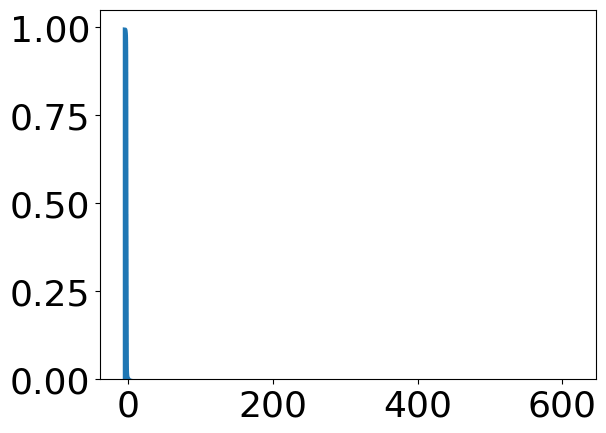

fourth moment
tensor(18317348.3532, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(0.2251, device='cuda:0', grad_fn=<MeanBackward0>), tensor(48.9340, device='cuda:0', grad_fn=<MeanBackward0>), tensor(86.9848, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7649.3612, device='cuda:0', grad_fn=<SubBackward0>))


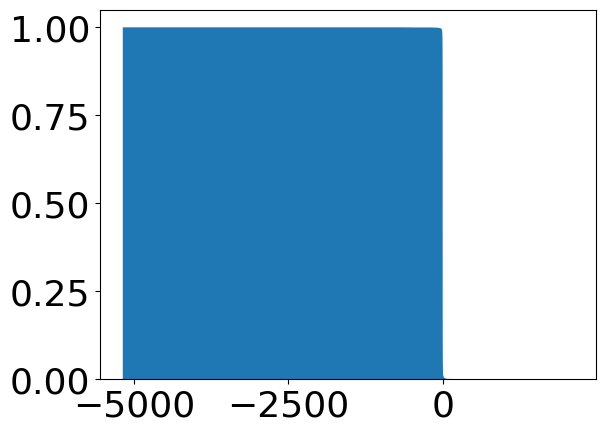

fourth moment
tensor(9.4690e+10, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(-0.2115, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4293.4670, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-58.5877, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5131.8057, device='cuda:0', grad_fn=<SubBackward0>))


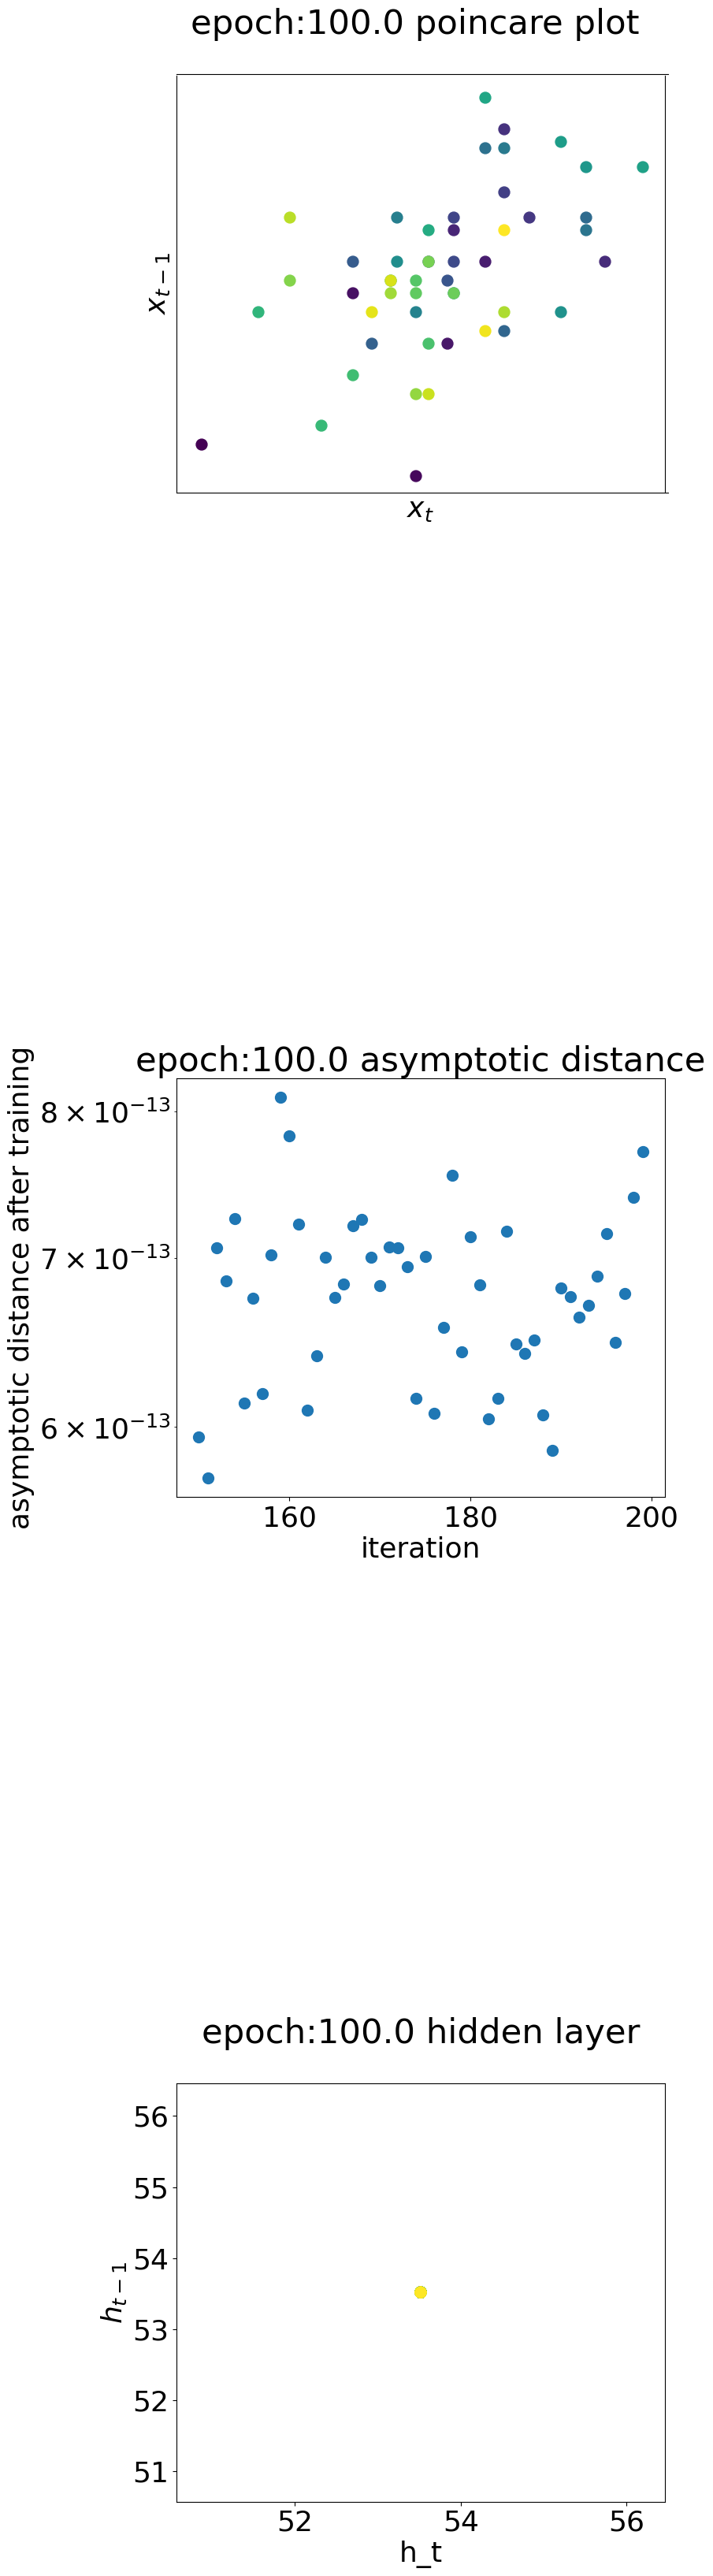

epoch : 101/1000, training loss = 0.461626,validation loss = 0.461335
epoch : 102/1000, training loss = 0.461292,validation loss = 0.462005
epoch : 103/1000, training loss = 0.460974,validation loss = 0.459451
epoch : 104/1000, training loss = 0.459577,validation loss = 0.458148
epoch : 105/1000, training loss = 0.458924,validation loss = 0.458267
epoch : 106/1000, training loss = 0.458528,validation loss = 0.457659
epoch : 107/1000, training loss = 0.458216,validation loss = 0.457375
epoch : 108/1000, training loss = 0.457460,validation loss = 0.456257
epoch : 109/1000, training loss = 0.456941,validation loss = 0.456135
epoch : 110/1000, training loss = 0.456740,validation loss = 0.455057
epoch : 111/1000, training loss = 0.455519,validation loss = 0.455443
epoch : 112/1000, training loss = 0.455043,validation loss = 0.454164
epoch : 113/1000, training loss = 0.454992,validation loss = 0.454799
epoch : 114/1000, training loss = 0.454717,validation loss = 0.453618
epoch : 115/1000, tr

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.9921)
tensor(0.0103)
tensor(0.9954)
tensor(0.9843)
tensor(0.0103)
tensor(0.9954)
tensor(0.9766)
tensor(0.0103)
tensor(0.9954)
tensor(0.9689)
tensor(0.0103)
tensor(0.9954)
tensor(0.9612)
tensor(0.0103)
tensor(0.9954)
tensor(0.9537)
tensor(0.0103)
tensor(0.9954)
tensor(0.9462)
tensor(0.0103)
tensor(0.9954)
tensor(0.9387)
tensor(0.0103)
tensor(0.9954)
tensor(0.9313)
tensor(0.0103)
tensor(0.9954)
tensor(0.9240)
tensor(0.0103)
tensor(0.9954)
tensor(0.9167)
tensor(0.0103)
tensor(0.9954)
tensor(0.9095)
tensor(0.0103)
tensor(0.9954)
tensor(0.9023)
tensor(0.0103)
tensor(0.9954)
tensor(0.8952)
tensor(0.0103)
tensor(0.9954)
tensor(0.8882)
tensor(0.0103)
tensor(0.9954)
tensor(0.8812)
tensor(0.0103)
tensor(0.9954)
tensor(0.8742)
tensor(0.0103)
tensor(0.9954)
tensor(0.8673)
tensor(0.0103)
tensor(0.9954)
tensor(0.8605)
tensor(0.0103)
tensor(0.9954)
tensor(0.8537)
tensor(0.0103)
tensor(0.9954)
tensor(0.8470)
tensor(0.0103)
tensor(0.9954)
tensor(0.8403)
tensor(0.0103)
tensor(0.9954)
tensor(0.8

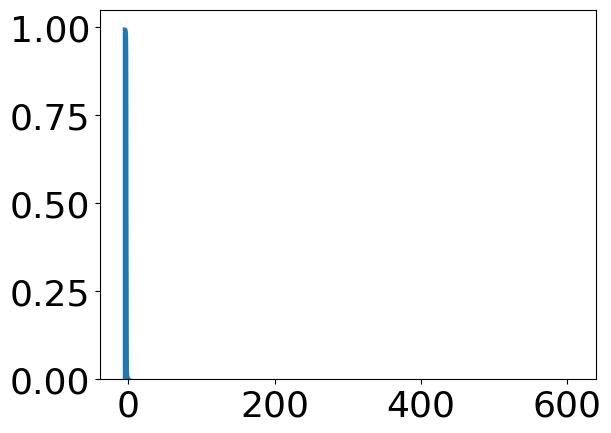

fourth moment
tensor(17561225.0911, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(0.2227, device='cuda:0', grad_fn=<MeanBackward0>), tensor(47.8998, device='cuda:0', grad_fn=<MeanBackward0>), tensor(87.0203, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7653.6818, device='cuda:0', grad_fn=<SubBackward0>))


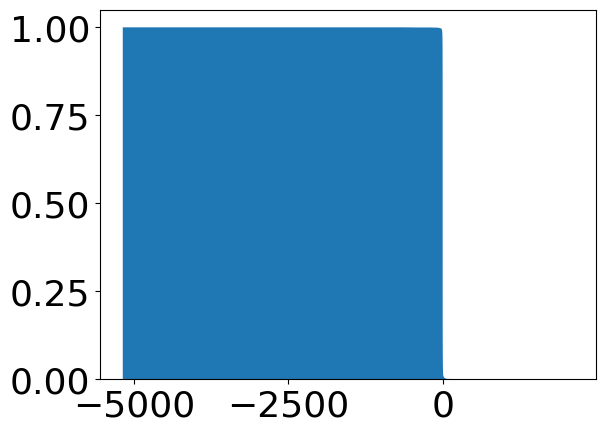

fourth moment
tensor(9.4690e+10, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(-0.2053, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4292.6572, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-58.6058, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5133.7101, device='cuda:0', grad_fn=<SubBackward0>))


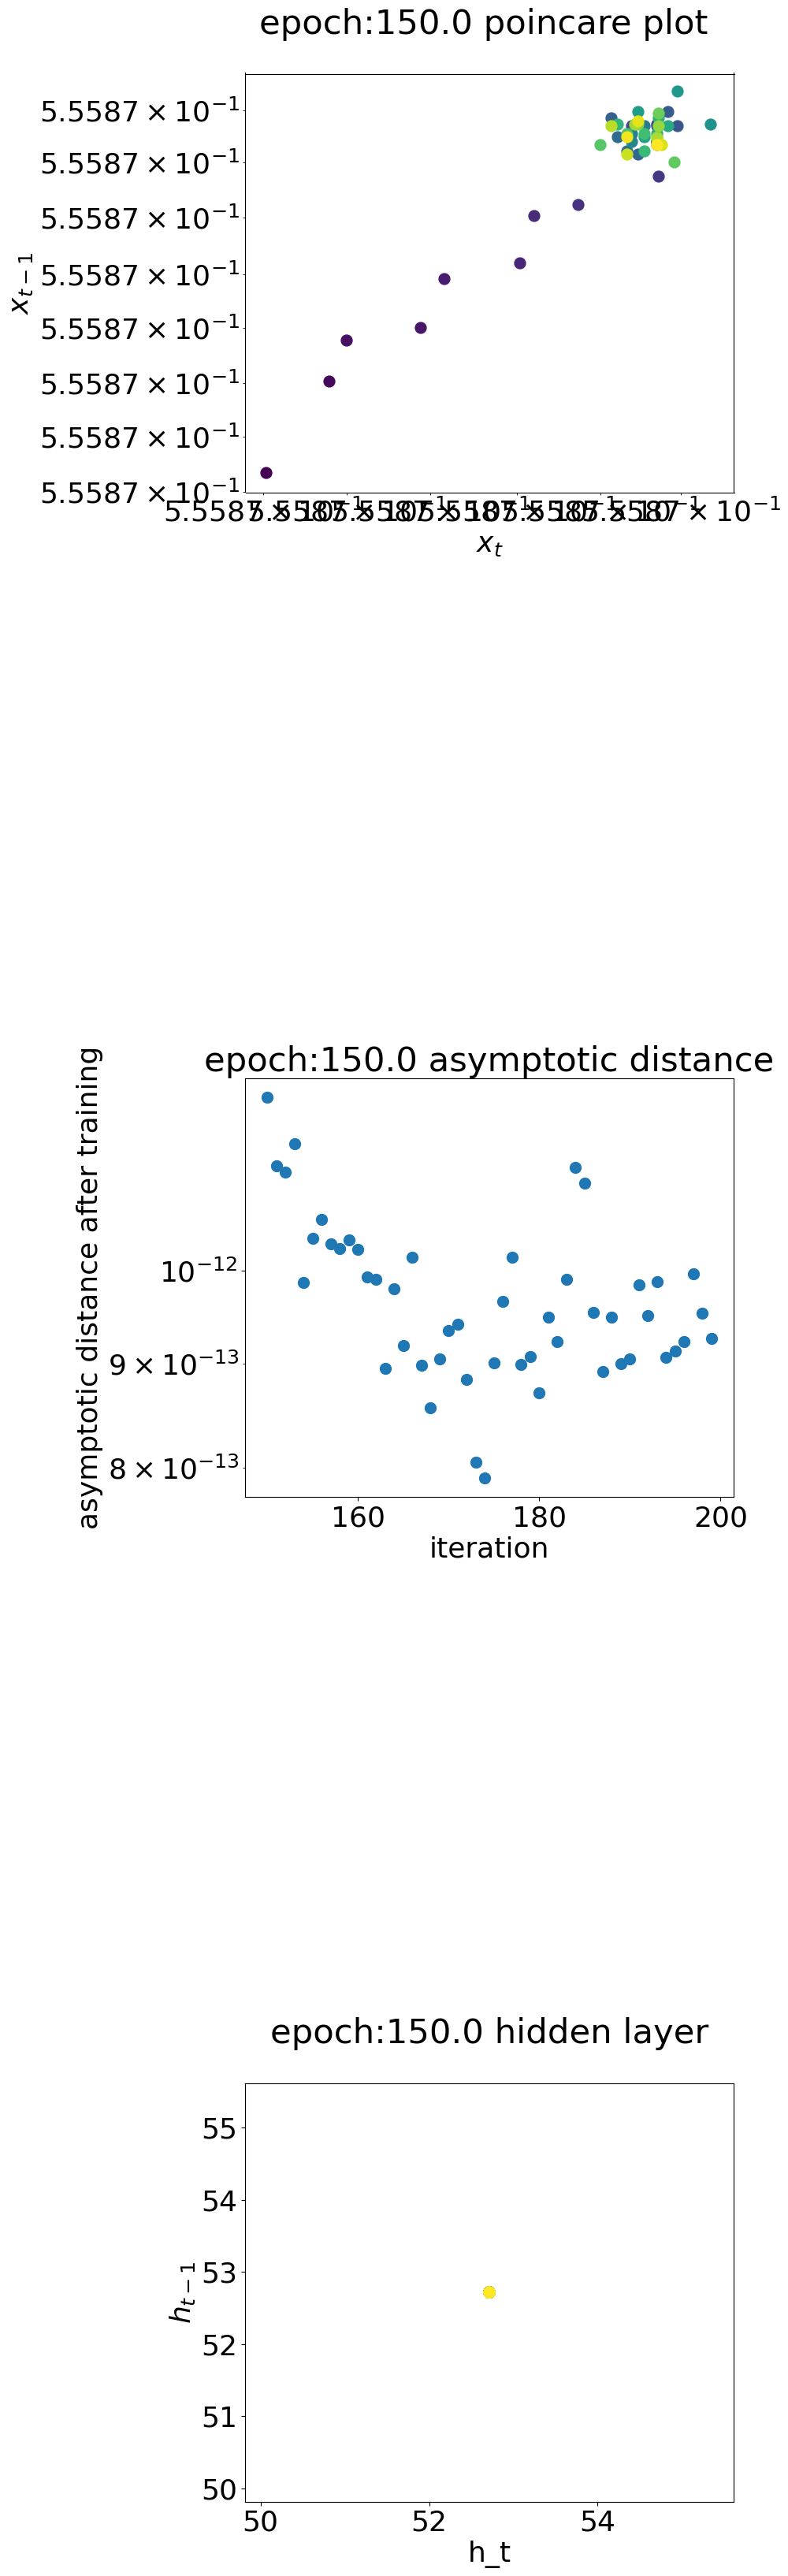

epoch : 151/1000, training loss = 0.445455,validation loss = 0.444280
epoch : 152/1000, training loss = 0.445166,validation loss = 0.444792
epoch : 153/1000, training loss = 0.445182,validation loss = 0.444499
epoch : 154/1000, training loss = 0.445221,validation loss = 0.444082
epoch : 155/1000, training loss = 0.445031,validation loss = 0.443725
epoch : 156/1000, training loss = 0.444968,validation loss = 0.444227
epoch : 157/1000, training loss = 0.444987,validation loss = 0.443959
epoch : 158/1000, training loss = 0.444898,validation loss = 0.444839
epoch : 159/1000, training loss = 0.444405,validation loss = 0.443824
epoch : 160/1000, training loss = 0.444373,validation loss = 0.443461
epoch : 161/1000, training loss = 0.444330,validation loss = 0.444088
epoch : 162/1000, training loss = 0.444479,validation loss = 0.445196
epoch : 163/1000, training loss = 0.443944,validation loss = 0.443279
epoch : 164/1000, training loss = 0.443959,validation loss = 0.443352
epoch : 165/1000, tr

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.9883)
tensor(0.0002)
tensor(0.9916)
tensor(0.9767)
tensor(0.0002)
tensor(0.9916)
tensor(0.9652)
tensor(0.0002)
tensor(0.9916)
tensor(0.9539)
tensor(0.0002)
tensor(0.9916)
tensor(0.9427)
tensor(0.0002)
tensor(0.9916)
tensor(0.9316)
tensor(0.0002)
tensor(0.9916)
tensor(0.9207)
tensor(0.0002)
tensor(0.9916)
tensor(0.9099)
tensor(0.0002)
tensor(0.9916)
tensor(0.8993)
tensor(0.0002)
tensor(0.9916)
tensor(0.8887)
tensor(0.0002)
tensor(0.9916)
tensor(0.8783)
tensor(0.0002)
tensor(0.9916)
tensor(0.8680)
tensor(0.0002)
tensor(0.9916)
tensor(0.8578)
tensor(0.0002)
tensor(0.9916)
tensor(0.8478)
tensor(0.0002)
tensor(0.9916)
tensor(0.8378)
tensor(0.0002)
tensor(0.9916)
tensor(0.8280)
tensor(0.0002)
tensor(0.9916)
tensor(0.8183)
tensor(0.0002)
tensor(0.9916)
tensor(0.8087)
tensor(0.0002)
tensor(0.9916)
tensor(0.7992)
tensor(0.0002)
tensor(0.9916)
tensor(0.7898)
tensor(0.0002)
tensor(0.9916)
tensor(0.7806)
tensor(0.0002)
tensor(0.9916)
tensor(0.7714)
tensor(0.0002)
tensor(0.9916)
tensor(0.7

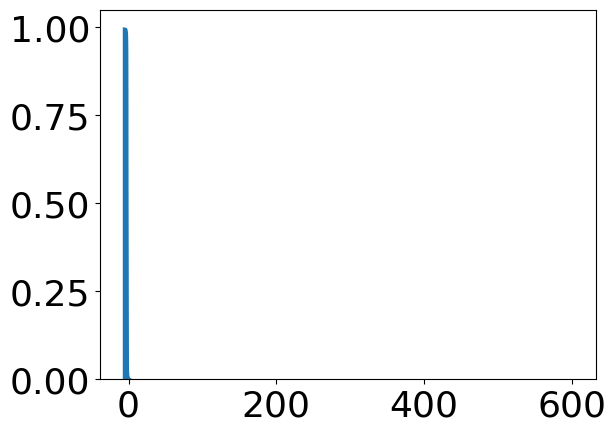

fourth moment
tensor(16826376.9079, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(0.2176, device='cuda:0', grad_fn=<MeanBackward0>), tensor(46.8751, device='cuda:0', grad_fn=<MeanBackward0>), tensor(87.0491, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7657.2873, device='cuda:0', grad_fn=<SubBackward0>))


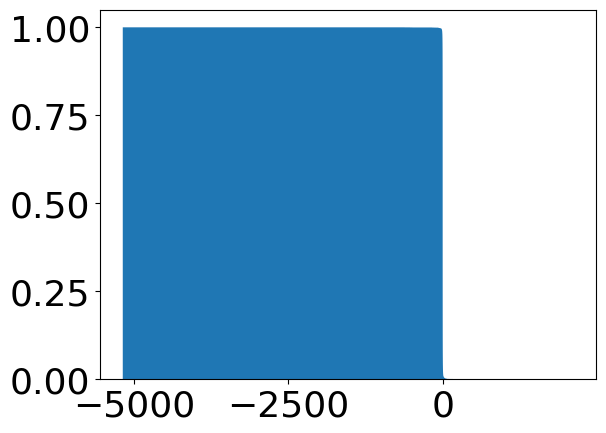

fourth moment
tensor(9.4689e+10, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(-0.2028, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4291.9733, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-58.6210, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5135.3116, device='cuda:0', grad_fn=<SubBackward0>))


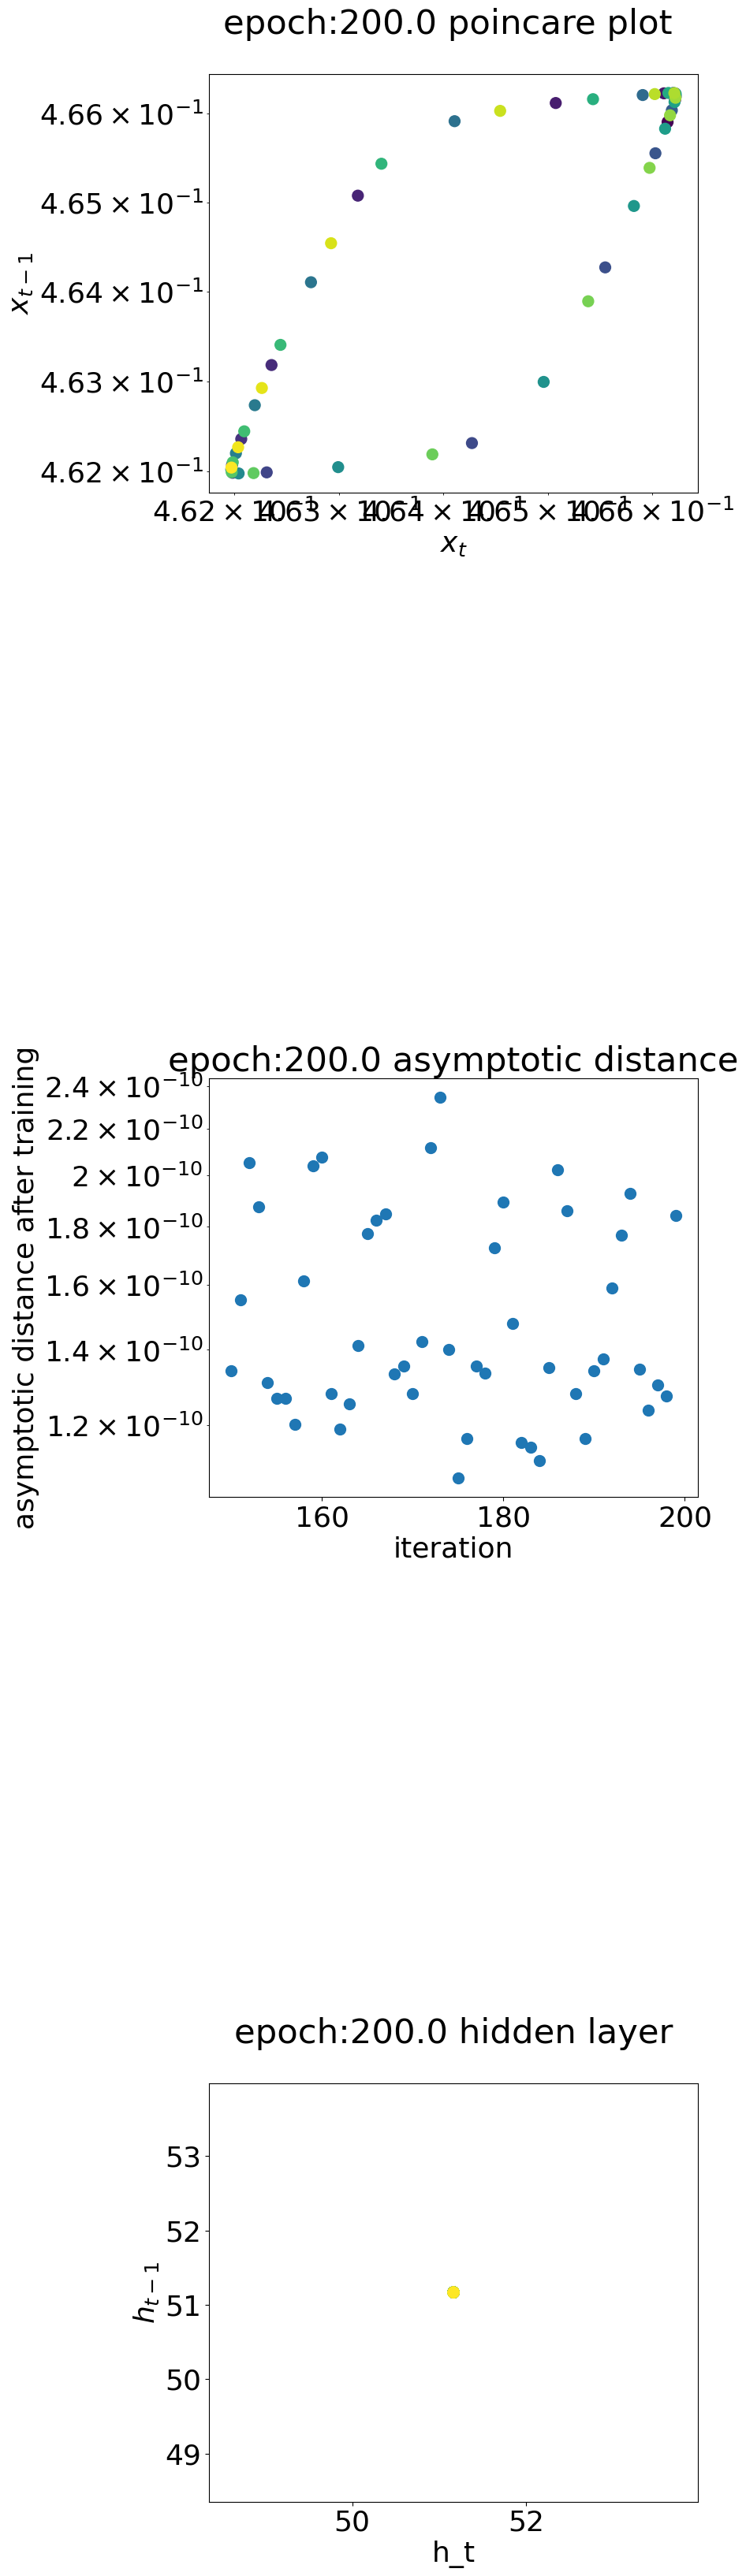

epoch : 201/1000, training loss = 0.438822,validation loss = 0.438053
epoch : 202/1000, training loss = 0.438940,validation loss = 0.438902
epoch : 203/1000, training loss = 0.438757,validation loss = 0.437828
epoch : 204/1000, training loss = 0.438893,validation loss = 0.437942
epoch : 205/1000, training loss = 0.438678,validation loss = 0.437973
epoch : 206/1000, training loss = 0.438734,validation loss = 0.438327
epoch : 207/1000, training loss = 0.438502,validation loss = 0.436957
epoch : 208/1000, training loss = 0.438349,validation loss = 0.437469
epoch : 209/1000, training loss = 0.438229,validation loss = 0.436958
epoch : 210/1000, training loss = 0.438356,validation loss = 0.437470
epoch : 211/1000, training loss = 0.437790,validation loss = 0.437535
epoch : 212/1000, training loss = 0.437425,validation loss = 0.436841
epoch : 213/1000, training loss = 0.437243,validation loss = 0.436395
epoch : 214/1000, training loss = 0.437429,validation loss = 0.436448
epoch : 215/1000, tr

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.9823)
tensor(4.9813e-07)
tensor(0.9856)
tensor(0.9649)
tensor(4.9407e-07)
tensor(0.9856)
tensor(0.9479)
tensor(4.9327e-07)
tensor(0.9856)
tensor(0.9311)
tensor(4.9762e-07)
tensor(0.9856)
tensor(0.9146)
tensor(4.8918e-07)
tensor(0.9856)
tensor(0.8984)
tensor(4.9176e-07)
tensor(0.9856)
tensor(0.8825)
tensor(4.8934e-07)
tensor(0.9856)
tensor(0.8669)
tensor(4.9368e-07)
tensor(0.9856)
tensor(0.8516)
tensor(5.0098e-07)
tensor(0.9856)
tensor(0.8365)
tensor(5.0289e-07)
tensor(0.9856)
tensor(0.8217)
tensor(4.8566e-07)
tensor(0.9856)
tensor(0.8071)
tensor(4.8188e-07)
tensor(0.9856)
tensor(0.7929)
tensor(4.8917e-07)
tensor(0.9856)
tensor(0.7788)
tensor(4.9871e-07)
tensor(0.9856)
tensor(0.7651)
tensor(5.0476e-07)
tensor(0.9856)
tensor(0.7515)
tensor(4.8878e-07)
tensor(0.9856)
tensor(0.7382)
tensor(4.8762e-07)
tensor(0.9856)
tensor(0.7252)
tensor(4.9801e-07)
tensor(0.9856)
tensor(0.7123)
tensor(4.9396e-07)
tensor(0.9856)
tensor(0.6997)
tensor(4.8964e-07)
tensor(0.9856)
tensor(0.6873)
tenso

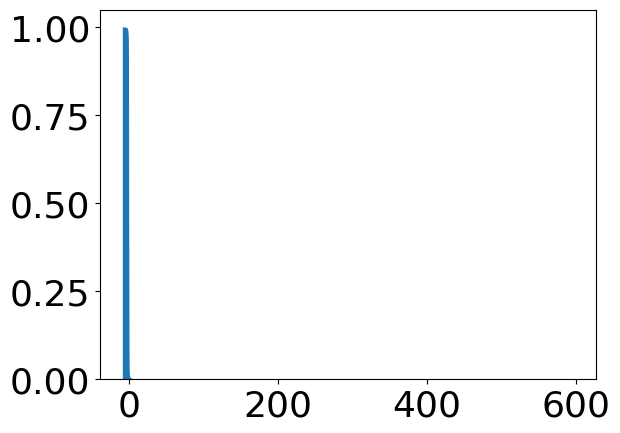

fourth moment
tensor(16171175.5191, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(0.2091, device='cuda:0', grad_fn=<MeanBackward0>), tensor(45.9467, device='cuda:0', grad_fn=<MeanBackward0>), tensor(87.0620, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7658.9538, device='cuda:0', grad_fn=<SubBackward0>))


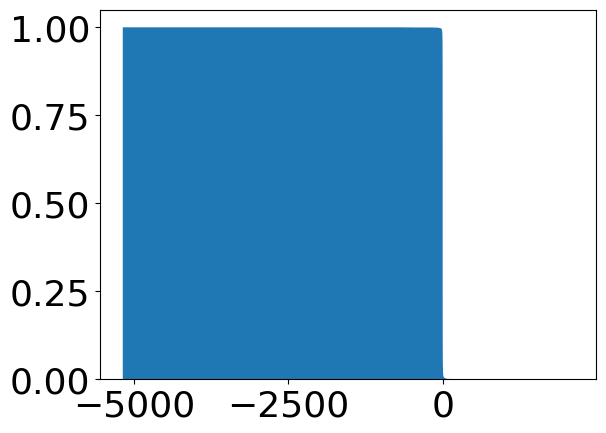

fourth moment
tensor(9.4688e+10, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(-0.2001, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4291.3703, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-58.6342, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5136.7254, device='cuda:0', grad_fn=<SubBackward0>))


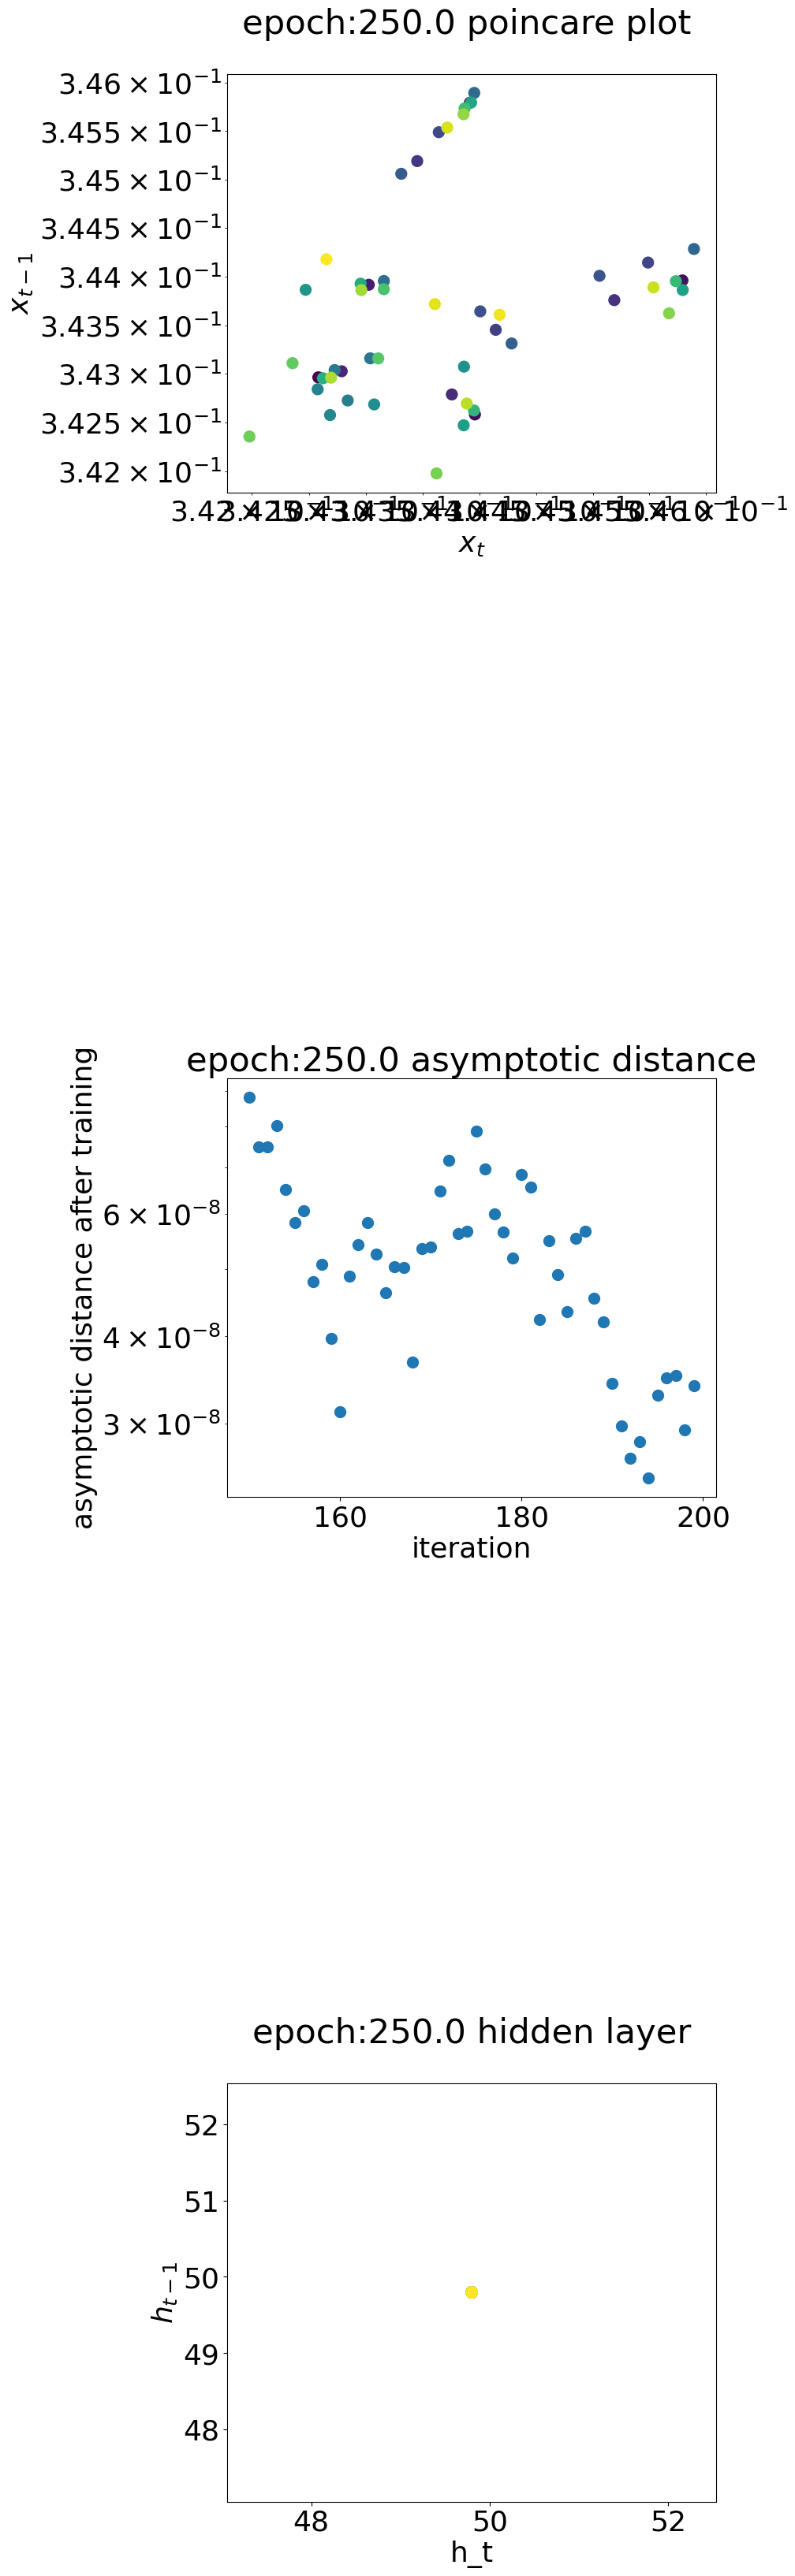

epoch : 251/1000, training loss = 0.432934,validation loss = 0.432326
epoch : 252/1000, training loss = 0.432691,validation loss = 0.431865
epoch : 253/1000, training loss = 0.432689,validation loss = 0.431777
epoch : 254/1000, training loss = 0.432668,validation loss = 0.431714
epoch : 255/1000, training loss = 0.432693,validation loss = 0.431309
epoch : 256/1000, training loss = 0.432675,validation loss = 0.431315
epoch : 257/1000, training loss = 0.432305,validation loss = 0.431793
epoch : 258/1000, training loss = 0.432109,validation loss = 0.431268
epoch : 259/1000, training loss = 0.431880,validation loss = 0.431731
epoch : 260/1000, training loss = 0.431811,validation loss = 0.430256
epoch : 261/1000, training loss = 0.431815,validation loss = 0.431208
epoch : 262/1000, training loss = 0.431557,validation loss = 0.430446
epoch : 263/1000, training loss = 0.431463,validation loss = 0.430545
epoch : 264/1000, training loss = 0.431460,validation loss = 0.430204
epoch : 265/1000, tr

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.9829)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.9660)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.9495)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.9332)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.9173)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.9016)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.8861)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.8709)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.8560)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.8414)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.8270)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.8128)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7989)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7852)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7718)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7585)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7456)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7328)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7202)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.7079)
tensor(8.8312e-07)
tensor(0.9862)
tensor(0.6958)
tenso

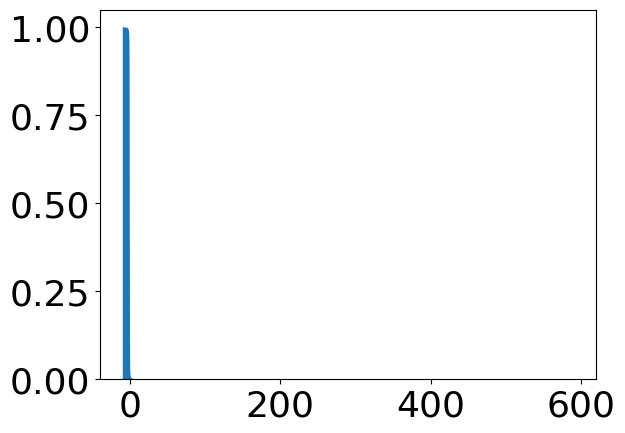

fourth moment
tensor(15476027.3656, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(0.2038, device='cuda:0', grad_fn=<MeanBackward0>), tensor(44.9385, device='cuda:0', grad_fn=<MeanBackward0>), tensor(87.0866, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7662.0357, device='cuda:0', grad_fn=<SubBackward0>))


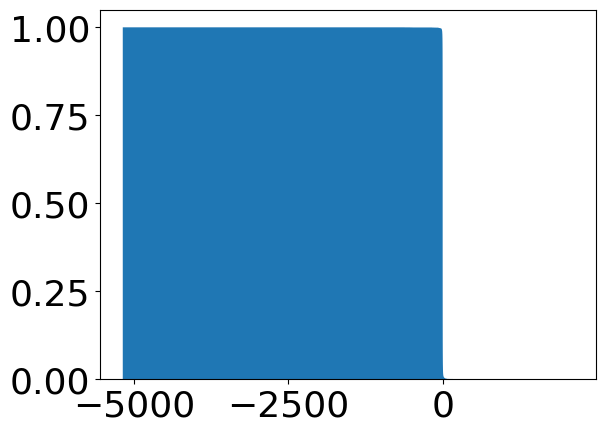

fourth moment
tensor(9.4687e+10, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(-0.1986, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4290.8349, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-58.6461, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5137.9787, device='cuda:0', grad_fn=<SubBackward0>))


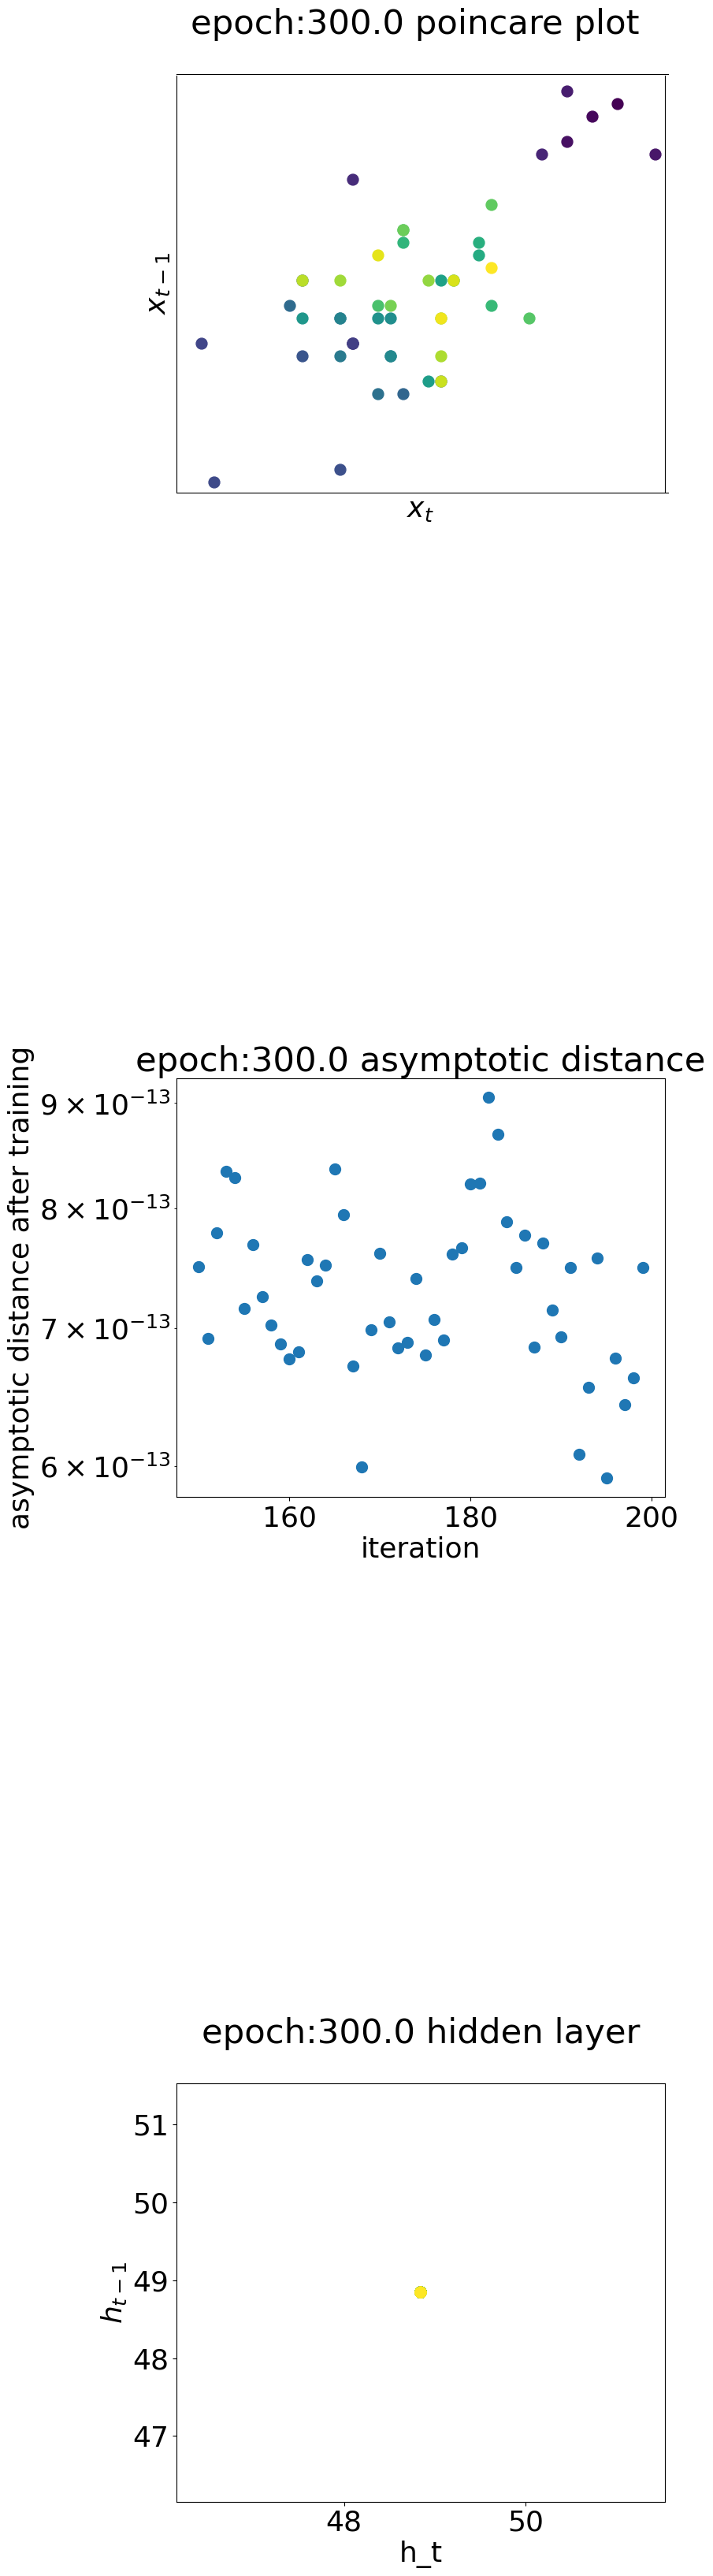

epoch : 301/1000, training loss = 0.429072,validation loss = 0.430111
epoch : 302/1000, training loss = 0.428900,validation loss = 0.427468
epoch : 303/1000, training loss = 0.428504,validation loss = 0.427791
epoch : 304/1000, training loss = 0.428640,validation loss = 0.428151
epoch : 305/1000, training loss = 0.428624,validation loss = 0.427611
epoch : 306/1000, training loss = 0.428406,validation loss = 0.427566
epoch : 307/1000, training loss = 0.428612,validation loss = 0.427888
epoch : 308/1000, training loss = 0.428453,validation loss = 0.427465
epoch : 309/1000, training loss = 0.428421,validation loss = 0.427344
epoch : 310/1000, training loss = 0.428410,validation loss = 0.427630
epoch : 311/1000, training loss = 0.428447,validation loss = 0.427287
epoch : 312/1000, training loss = 0.428412,validation loss = 0.427413
epoch : 313/1000, training loss = 0.428474,validation loss = 0.427192
epoch : 314/1000, training loss = 0.428207,validation loss = 0.427454
epoch : 315/1000, tr

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:776: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


tensor(0.9785)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.9574)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.9368)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.9166)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.8968)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.8775)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.8586)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.8401)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.8220)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.8043)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.7870)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.7700)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.7534)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.7372)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.7213)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.7058)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.6906)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.6757)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.6611)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.6469)
tensor(9.7557e-09)
tensor(0.9817)
tensor(0.6330)
tenso

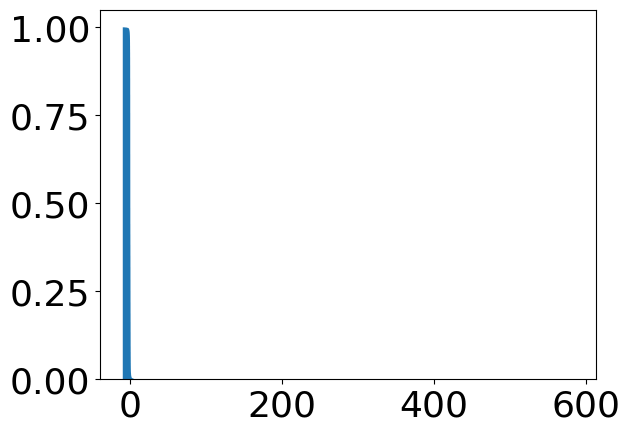

fourth moment
tensor(14857814.9096, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(0.1977, device='cuda:0', grad_fn=<MeanBackward0>), tensor(44.0180, device='cuda:0', grad_fn=<MeanBackward0>), tensor(87.1231, device='cuda:0', grad_fn=<MeanBackward0>), tensor(7666.4854, device='cuda:0', grad_fn=<SubBackward0>))


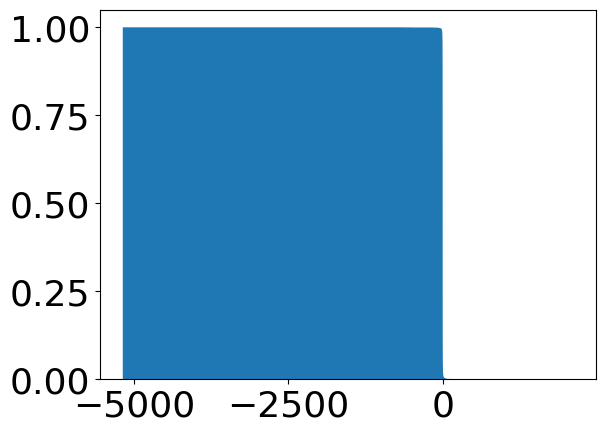

fourth moment
tensor(9.4687e+10, device='cuda:0', grad_fn=<MeanBackward0>)
(tensor(-0.1982, device='cuda:0', grad_fn=<MeanBackward0>), tensor(4290.3255, device='cuda:0', grad_fn=<MeanBackward0>), tensor(-58.6576, device='cuda:0', grad_fn=<MeanBackward0>), tensor(5139.1668, device='cuda:0', grad_fn=<SubBackward0>))


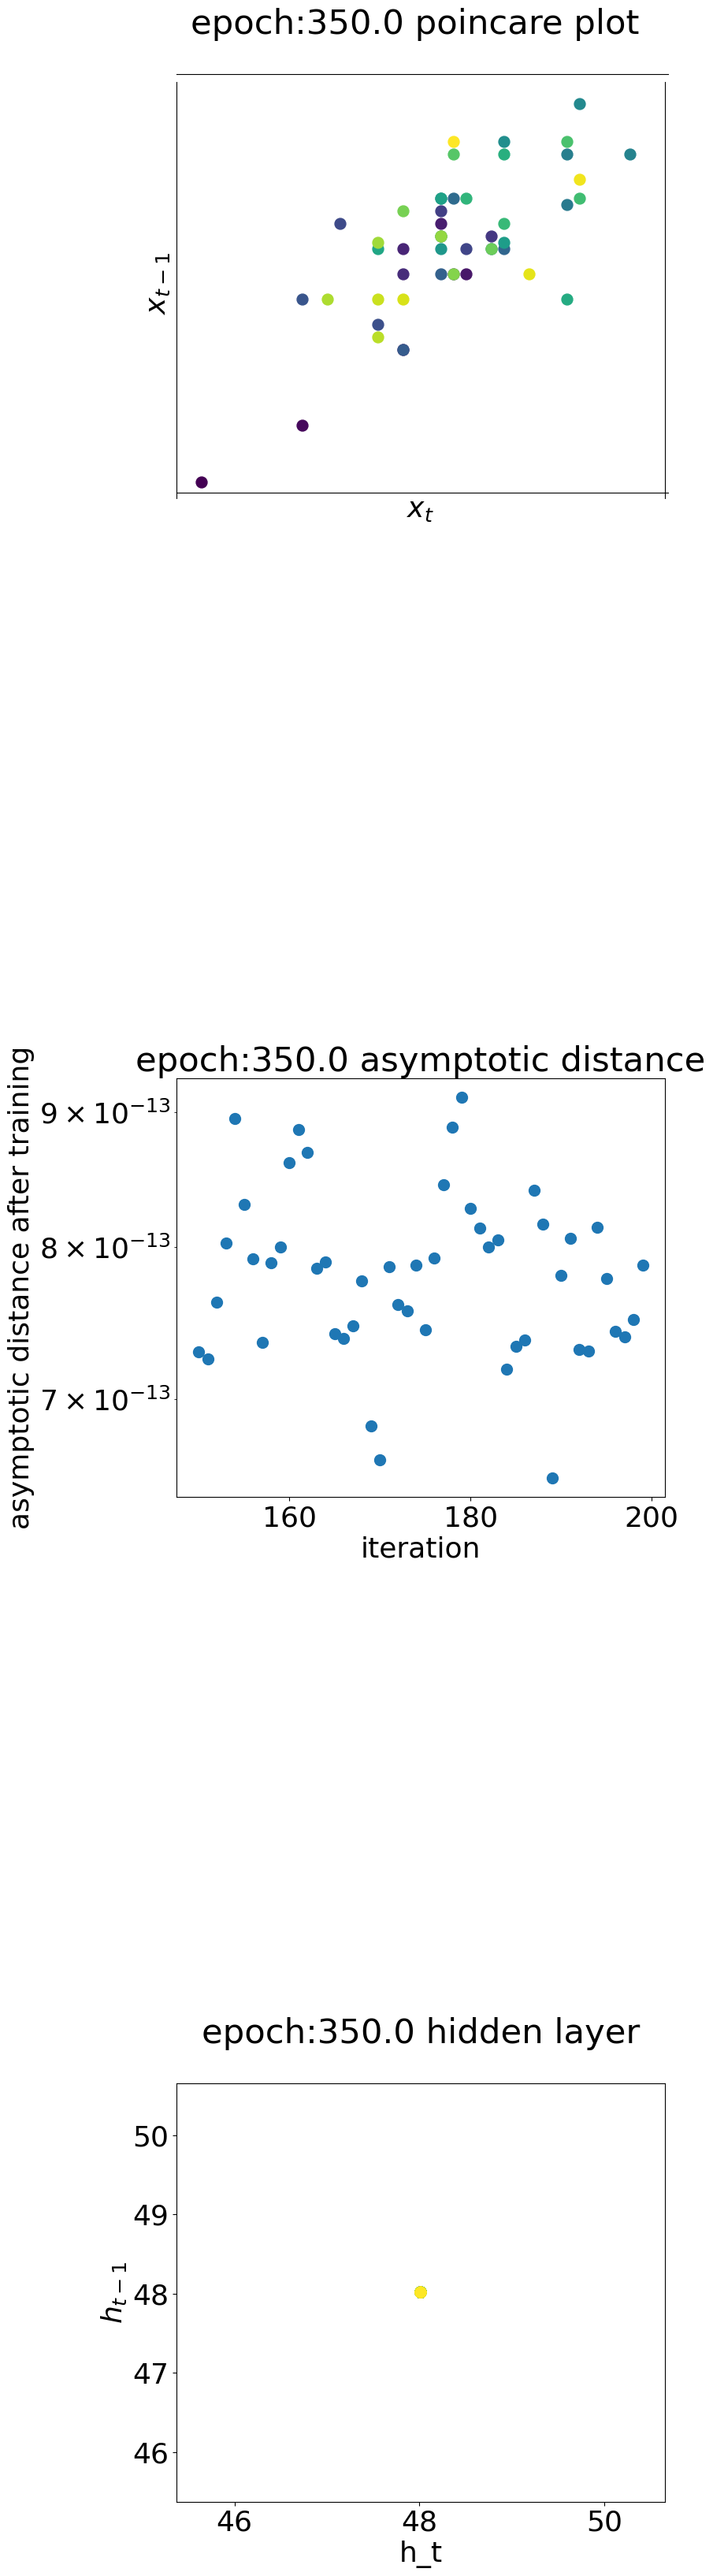

epoch : 351/1000, training loss = 0.423665,validation loss = 0.422492
epoch : 352/1000, training loss = 0.423598,validation loss = 0.422983
epoch : 359/1000, training loss = 0.422263,validation loss = 0.421053
epoch : 360/1000, training loss = 0.422215,validation loss = 0.420661
epoch : 361/1000, training loss = 0.421809,validation loss = 0.420995
epoch : 362/1000, training loss = 0.421759,validation loss = 0.420978
epoch : 363/1000, training loss = 0.421597,validation loss = 0.420303
epoch : 364/1000, training loss = 0.421542,validation loss = 0.420913
epoch : 365/1000, training loss = 0.421479,validation loss = 0.420261
epoch : 366/1000, training loss = 0.421038,validation loss = 0.420491
epoch : 367/1000, training loss = 0.421153,validation loss = 0.420671
epoch : 368/1000, training loss = 0.421124,validation loss = 0.420447
epoch : 369/1000, training loss = 0.421141,validation loss = 0.420820
epoch : 370/1000, training loss = 0.420754,validation loss = 0.418744
epoch : 371/1000, tr

In [ ]:

spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
#diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=True
chao=[]
mu=1
dmu=1/epochs
noise_print=False
for epoch in range(epochs):
    loss = 0
    mu=mu+dmu
    model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [1000, 784] matrix
        # load it to the active device
        input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        
        batch_feature=batch_features.view(batch_size,-1)
        #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)8
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,batch_feature.to(device))
        
        if init_compute==True and epoch%interval==0:
            torch.save(model.state_dict(), "epoch:"+str(epoch)+".pt")
                #print("here")Trues 
                #print(train_loss)
            save_image=input_image
                #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
            perturbed_inputs=add_gaussian_noise(input_image,perturbation_strength)
                #print("perturbed_inputs")
                #print(torch.norm(perturbed_inputs))
            cutoff=[]
            for j in range(no_of_images):
                cutoff.append(torch.norm(perturbed_inputs[j]-input_image[j]))
            model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
            model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
            #model_clone.eval() 
            #print(cutoff)
            x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_inputs,epoch)
            x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
            #print("there")
            ##print(torch.norm(y_pred_perturbed))
            #print(torch.norm(y_pred_unperturbed))
            distance,hidden,chaos,ave_jac=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoff)
                
            asymptotic_dist.append(distance[-1])
            chao.append(chaos)
            print(ave_jac)
            plt.scatter(x=np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),y=distance,s=100)
            plt.xlabel("iteration")
            plt.ylabel("asymptotic distance")
            plt.yscale("log")
            plt.title("epoch:{:.1f} asymptotic distance before training".format(epoch))
            np.savetxt("asymptotic distance"+str(epoch)+".txt",distance)
            plt.savefig("initial asymptotic state.jpg")
            plt.show()
            #average_jacobian=[]
            #spectral_radiuses=[]
            init_compute=False
        # compute accumulated gradients
     
    
        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)



In [ ]:
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)

print(chao)
font = {
        'size'   : 14}
plt.rc('font', **font)

intervals=50
x=np.arange(1,(epochs+intervals)/intervals+1)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao,label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/"+str(interval))
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("percentage of image in chaos.jpg")

np.savetxt("percentage of chaos.txt",chao)
plt.show()









print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg",)

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

print("average jacobian")
print(len(average_jacobian))
plt.scatter(x[1:],y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
plt.ylabel("average jacobian")
plt.xlabel("epoch/"+str(interval))
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("average_jacobian.jpg")
np.savetxt("average jacobian.txt",average_jacobian)
plt.show()


#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg")

np.savetxt("spectral radius.txt",spectral_radiuses)
plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg")
plt.show()
#print("asymptotic distance")
plot_loss=[]
for i in range(len(validation_loss)):
    if i%intervals==0:
        plot_loss.append(validation_loss[i])
fig, ax1 = plt.subplots()
xx=np.arange(1,epochs/intervals+1)
color = 'tab:red'
ax1.set_xlabel('epoch/'+str(intervals))
ax1.set_ylabel('validation loss', color=color)
ax1.scatter(xx,y=plot_loss, label="validation loss",color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('asymptotic distance', color=color)  # we already handled the x-label with ax1
ax2.scatter(x,y=asymptotic_dist, color=color,label="asymptotic distance")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.scatter(xx,plot_loss,label="validation loss")
        
        
        
#plt.plot(x,plot_loss,label="validation loss")
plt.scatter(x,y=asymptotic_dist,label="asymptotic distance")

#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg")

plt.show()
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

plt.plot(validation_loss)
plt.yscale("log")
plt.show()
plt.plot(training_loss)
plt.yscale("log")
plt.show()